# Analyzing  Speedtest Results

In [1]:
import os
import re
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import custom_module as M

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# gather all dicts into a master dict (of dicts)
master_dict = M.gather_dicts()

In [16]:
# create long pandas df
df_wide = pd.DataFrame.from_dict(master_dict)
df_long = df_wide.T
df_long.index = range(len(df_long))
df_long

,test,day,location,computer,access_point,data
0,1,2022-09-04,upper_west,HP ProBook 450 G5,None,"{'time': ['16:38:34', '16:39:47', '16:43:13', ..."
1,2,2022-09-04,upper_west,HP ProBook 450 G5,None,"{'time': ['18:27:12', '18:27:46', '18:29:34', ..."
2,3,2022-09-06,living_room,15Z95P-P.AAB8U1,None,"{'time': ['12:37:28', '12:40:30', '12:41:04', ..."
3,4,2022-09-06,upper_east,15Z95P-P.AAB8U1,None,"{'time': ['12:51:39', '12:55:18', '12:57:19', ..."
4,5,2022-09-07,lower_west,HP ProBook 450 G5,None,"{'time': ['11:19:49', '11:25:05', '11:28:21', ..."


In [4]:
# The `data` col is a dict of time of day, jitter and latency in secs, and download and upload speeds in Mbps
df_long.loc[0,'data']

{'time': ['16:38:34', '16:39:47', '16:43:13', '16:45:29', '16:47:07'],
 'jitter': [1.044, 1.189, 1.904, 0.514, 2.18],
 'latency': [14.797, 13.487, 12.067, 13.509, 13.444],
 'download': [157.935456, 121.17854, 121.29388, 152.303892, 170.274728],
 'upload': [10.703478, 7.654459, 9.4381, 9.449713, 8.825212]}

The custom help function `plot_speeds` shows upload and download speeds (and an average download speed) for a single test suite (or test run) that includes typically 5 iterations or speed tests.

This is too zoomed in for insights given how our speeds vary per day, time of day, and computer used:

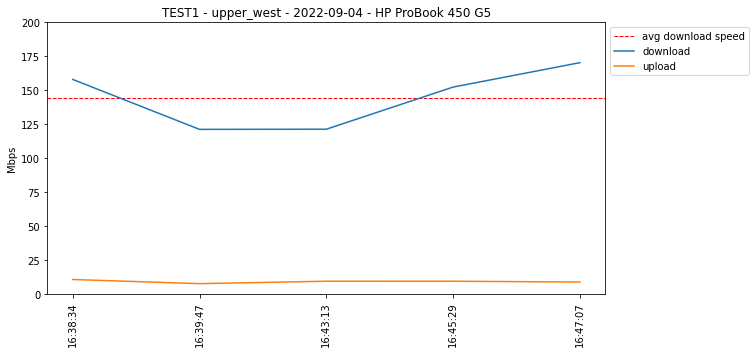

In [5]:
M.plot_speeds(df=df_wide, test='test1', iters=5, ymax=200); # defaults

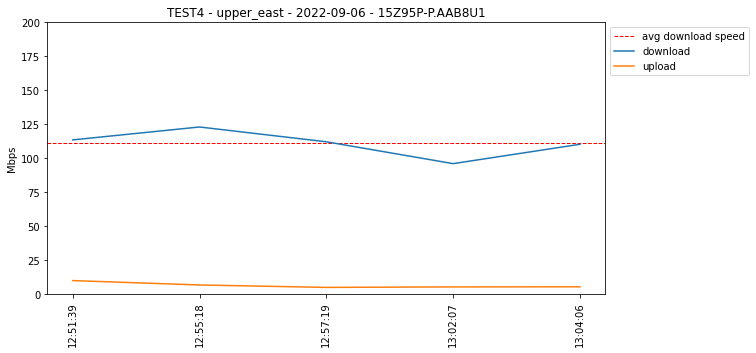

In [19]:
M.plot_speeds(df=df_wide, test='test4');

## Dates

Focusing on download speeds since that's most of our use case, I look at variance in download times given different dates:

In [20]:
date_df = M.transform_data(df_wide, "day")
date_df.iloc[:,:10]

,2022-09-04,2022-09-04,2022-09-06,2022-09-06,2022-09-07
0,157.935456,112.440335,119.241076,113.436254,158.907815
1,121.178540,108.056060,94.396195,122.929118,115.414416
2,121.293880,103.397200,109.327660,112.037480,173.922456
3,152.303892,91.695235,77.585152,95.961420,100.212940
4,170.274728,180.695053,107.714420,110.211304,125.396480


Since it's hard to get a sense by looking at numbers, we can plot a __heatmap__:

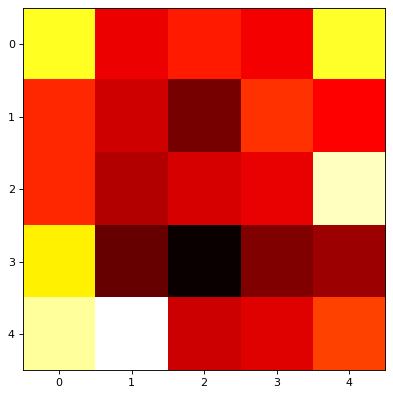

In [21]:
fig=plt.figure(figsize=(15, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(date_df, cmap='hot', interpolation='nearest')
plt.show()

There's a lot of variation but we can see how some tests result in lower speeds and others in higher speeds by looking at the vertical bands.

Another way to visualize this would be __boxplots__ to show the variation `within` and `in-between` tests:

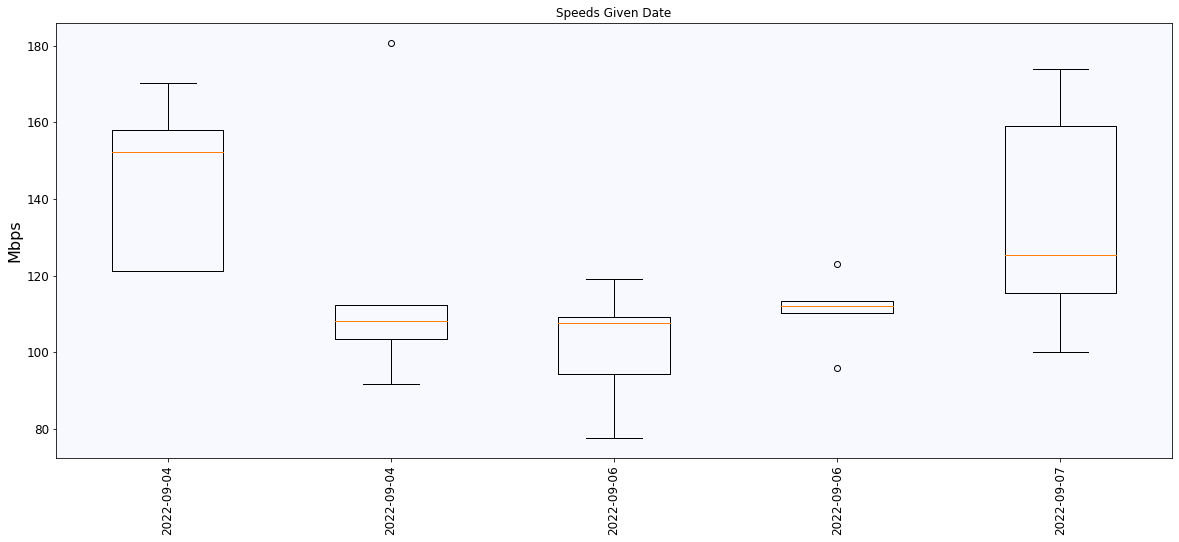

In [22]:
# misses aggregating by Date...

M.plot_results(date_df, "Date")

## Laptop location

The laptop's location matters but so does the location of the router during a given test, and another confounder is the laptop used.

Since my data collection strategy was evolving and less than optimal, stratification leads to incomplete sample sizes. A large subsample comes from the "upper east" room:

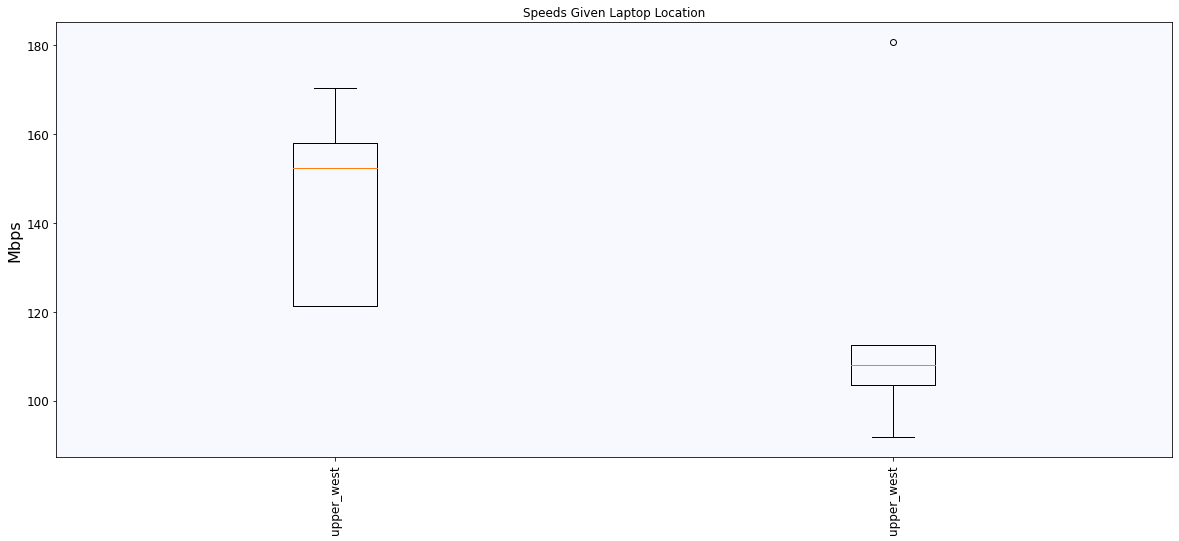

In [25]:
# also misses aggregation

loc_df = M.transform_data(df_wide, 'location')

M.plot_results(loc_df[['upper_west']], "Laptop Location")

In [26]:
df_long[df_long['location']=='upper_west']

,test,day,location,computer,access_point,data
0,1,2022-09-04,upper_west,HP ProBook 450 G5,None,"{'time': ['16:38:34', '16:39:47', '16:43:13', ..."
1,2,2022-09-04,upper_west,HP ProBook 450 G5,None,"{'time': ['18:27:12', '18:27:46', '18:29:34', ..."


Here I compare upper west and lower west locations:

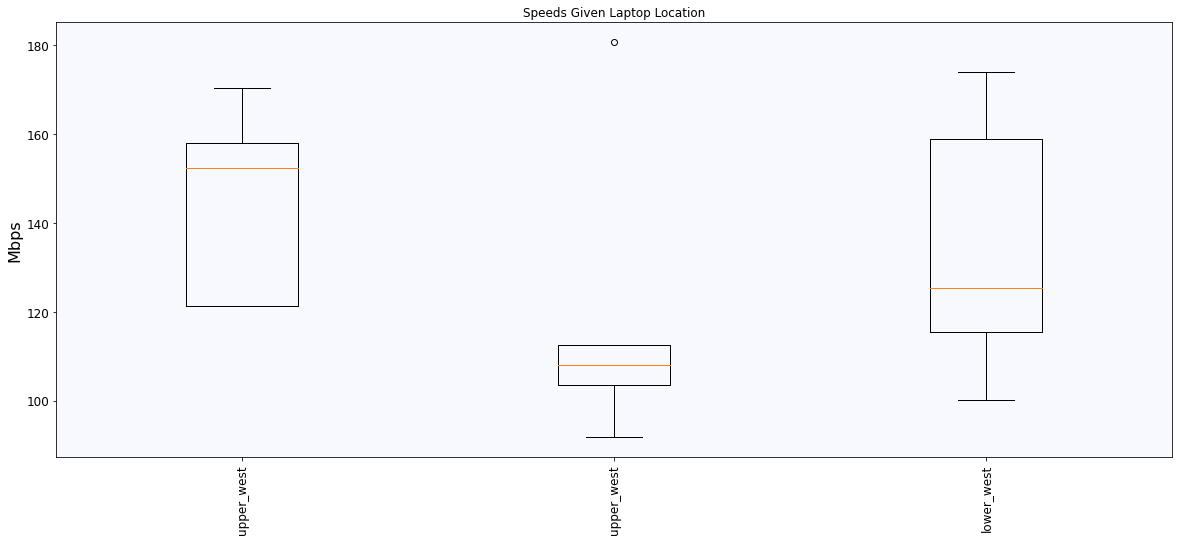

In [27]:
M.plot_results(loc_df[['upper_west', 'lower_west']], "Laptop Location")

The data is noisy. First I have some "good luck" with speeds even though I'm in the upper west room and the router is in the living room (downstairs), but then the speeds decrease and I move the router to the hallway upstairs (where it lives now) and speeds improve initially but decrease as well. 

Despite the smaller number of tests in the lower west room (where I work), I get a significant decrease of speeds by moving the router to the hallway upstairs.

In [28]:
df_long[df_long['location'].isin(['upper_west', 'lower_west'])]\
    .sort_values(by=['location','test'], ascending=[False, True])

,test,day,location,computer,access_point,data
0,1,2022-09-04,upper_west,HP ProBook 450 G5,None,"{'time': ['16:38:34', '16:39:47', '16:43:13', ..."
1,2,2022-09-04,upper_west,HP ProBook 450 G5,None,"{'time': ['18:27:12', '18:27:46', '18:29:34', ..."
4,5,2022-09-07,lower_west,HP ProBook 450 G5,None,"{'time': ['11:19:49', '11:25:05', '11:28:21', ..."



## Computer

All this is of cousre confounded by the old vs new laptops, which as you'd expect, show the clearest signals.

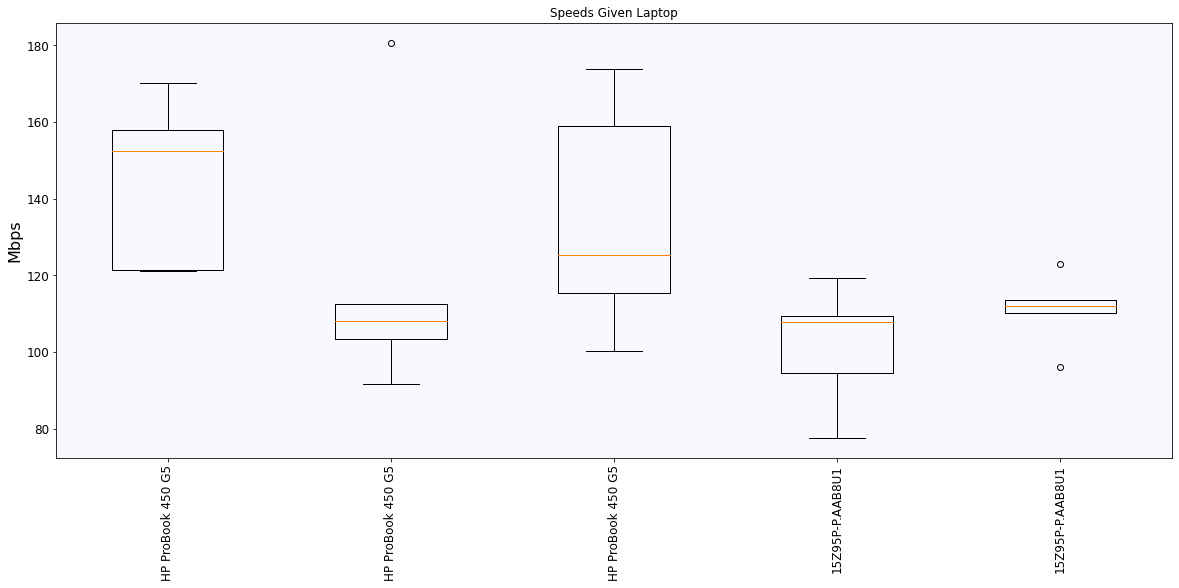

In [29]:
# HP laptops
comp_df = M.transform_data(df_wide, "computer")
M.plot_results(comp_df[['HP ProBook 450 G5', '15Z95P-P.AAB8U1']], "Laptop")

The newer HP ProBook gets greater speeds but also has its bad moments and greater variance than I'd have hoped for.

In [30]:
# Dell laptops
#M.plot_results(comp_df[['Inspiron 13-5378', 'Dell System Inspiron N7110']], "Dell Laptops", scale=.7)

*Statistics* vs *common sense*:
- I was mostly concerned about speeds for the old Dell so I did not test the new Dell more than once, which is statistically unsound but makes sense, I did not need more than one test to confirm what I knew and was experiencing. I also had less access to these computers.

---